In [26]:
import numpy as np

class DenseLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.zeros((1, output_dim))
        self.input = None
        self.d_weights = None
        self.d_bias = None  

    def forward(self, X):
        self.input = X
        return np.dot(X, self.weights) + self.bias

    def backward(self, d_out, learning_rate):
        self.d_weights = np.dot(self.input.T, d_out)
        self.d_bias = np.sum(d_out, axis=0, keepdims=True)
        d_input = np.dot(d_out, self.weights.T)
        return d_input

In [27]:
class ReLU:
    def forward(self, X):
        self.input = X
        return np.maximum(0, X)

    def backward(self, d_out):
        return d_out * (self.input > 0)

In [28]:
class BatchNormalization:
    def __init__(self, dim, epsilon=1e-5, momentum=0.9):
        self.gamma = np.ones(dim)
        self.beta = np.zeros(dim)
        self.epsilon = epsilon
        self.momentum = momentum
        self.running_mean = np.zeros(dim)
        self.running_var = np.zeros(dim)
        self.input = None

    def forward(self, X, training=True):
        if training:
            self.mean = np.mean(X, axis=0)
            self.var = np.var(X, axis=0)
            self.input = X

            self.X_norm = (X - self.mean) / np.sqrt(self.var + self.epsilon)
            out = self.gamma * self.X_norm + self.beta

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            X_norm = (X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            out = self.gamma * X_norm + self.beta
        
        return out

    def backward(self, d_out, learning_rate):
        N, D = d_out.shape

        X_mu = self.input - self.mean
        std_inv = 1. / np.sqrt(self.var + self.epsilon)

        dX_norm = d_out * self.gamma
        dvar = np.sum(dX_norm * X_mu, axis=0) * -0.5 * std_inv**3
        dmean = np.sum(dX_norm * -std_inv, axis=0) + dvar * np.mean(-2. * X_mu, axis=0)

        dX = (dX_norm * std_inv) + (dvar * 2 * X_mu / N) + (dmean / N)
        self.gamma -= learning_rate * np.sum(d_out * self.X_norm, axis=0)
        self.beta -= learning_rate * np.sum(d_out, axis=0)
        
        return dX


In [29]:
class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate

    def forward(self, X, training=True):
        if training:
            self.mask = np.random.rand(*X.shape) > self.dropout_rate
            return X * self.mask / (1 - self.dropout_rate)
        else:
            return X

    def backward(self, d_out):
        return d_out * self.mask / (1 - self.dropout_rate)


In [30]:
class AdamOptimizer:
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, params, grads):
        self.t += 1
        updated_params = {}

        for key in params:
            if key not in self.m:
                self.m[key] = [np.zeros_like(grads[key][0]),np.zeros_like(grads[key][1])]
                self.v[key] = [np.zeros_like(grads[key][0]),np.zeros_like(grads[key][1])]

            self.m[key][0] = self.beta1 * self.m[key][0] + (1 - self.beta1) * grads[key][0]
            self.m[key][1] = self.beta1 * self.m[key][1] + (1 - self.beta1) * grads[key][1]

            self.v[key][0] = self.beta2 * self.v[key][0] + (1 - self.beta2) * (grads[key][0] ** 2)
            self.v[key][1] = self.beta2 * self.v[key][1] + (1 - self.beta2) * (grads[key][1] ** 2)

            m_hat_weights = self.m[key][0] / (1 - self.beta1 ** self.t)
            m_hat_bias = self.m[key][1] / (1 - self.beta1 ** self.t)
            v_hat_weights = self.v[key][0] / (1 - self.beta2 ** self.t)
            v_hat_bias = self.v[key][1] / (1 - self.beta2 ** self.t)

            updated_params[key] =[params[key][0] - self.learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + self.epsilon),
                                    params[key][1] - self.learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + self.epsilon)]

        return updated_params



In [31]:
class Softmax:
    def forward(self, X):
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output

    def backward(self, d_out):
        return self.output * (d_out - np.sum(d_out * self.output, axis=1, keepdims=True))


In [32]:
class FeedForwardNeuralNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        self.layers = []
        
        # Adding first Dense layer
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(DenseLayer(prev_dim, hidden_dim))
            self.layers.append(BatchNormalization(hidden_dim))
            self.layers.append(ReLU())
            self.layers.append(Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Adding final Dense layer
        self.layers.append(DenseLayer(prev_dim, output_dim))
        self.layers.append(Softmax())

    def forward(self, X, training=True):
        # Forward pass through all layers
        for layer in self.layers:
            if isinstance(layer, (Dropout,BatchNormalization)):
                X = layer.forward(X, training)
            else:
                X = layer.forward(X)
        return X

    def backward(self, d_out, learning_rate):
        # Backward pass through all layers in reverse order
        for layer in reversed(self.layers):
            if isinstance(layer, (DenseLayer, BatchNormalization)):
                d_out = layer.backward(d_out, learning_rate)
            elif isinstance(layer, (ReLU, Dropout, Softmax)):
                d_out = layer.backward(d_out)

    def update_params(self, adam_optimizer):
        # Parameter and gradient dicts
        params = {}
        grads = {}
        
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                params[id(layer)] = [layer.weights,layer.bias]
                grads[id(layer)] = [layer.d_weights,layer.d_bias]
        
        # Updating parameters using Adam optimizer
        updated_params = adam_optimizer.update(params, grads)

        # Updating the layers with the new parameters
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                layer.weights = updated_params[id(layer)][0]
                layer.bias = updated_params[id(layer)][1]


In [33]:
from torchvision import datasets, transforms

# Define transformation
transform = transforms.ToTensor()

# Load the training dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# Load the test dataset separately
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

In [34]:
import tqdm
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix

class Model:
    def __init__(self,input_dim,hidden_dims,output_dim,dropout_rate,learning_rate,batch_size,num_epochs):
        # Hyperparameters
        self.input_dim = input_dim 
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim 
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.batch_size = batch_size 
        self.num_epochs = num_epochs

        # Initialize the fnn
        self.fnn = FeedForwardNeuralNetwork(self.input_dim, self.hidden_dims, self.output_dim, self.dropout_rate)
        self.adam_optimizer = AdamOptimizer(self.learning_rate)

    def fit(self,dataset,history,train):

        # Split the dataset for training and validation
        train_size = int(0.8 * len(dataset))  #!<-----------------------------------------------------------
        val_size = len(dataset) - train_size
        train_subset, val_subset = random_split(dataset, [train_size, val_size])

        # Create DataLoaders for training and validation subsets
        if train:
            train_loader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=self.batch_size, shuffle=False)
        else:
            train_loader = dataset

        # Training loop
        print(self.num_epochs)
        for epoch in range(self.num_epochs):
            epoch_loss = 0
            correct = 0
            total = 0

            for images, labels in tqdm.tqdm(train_loader):
                # Flatten images
                images = images.view(-1, 28 * 28).numpy()
                
                # Forward pass
                outputs = self.fnn.forward(images, training=True)
                
                # One-hot encoding for labels
                one_hot_labels = np.eye(self.output_dim)[labels.numpy()]

                # Compute loss (cross-entropy loss)
                loss = -np.sum(one_hot_labels * np.log(outputs + 1e-8)) / len(labels)
                epoch_loss += loss

                # Backward pass
                d_out = outputs - np.eye(self.output_dim)[labels.numpy()]
                self.fnn.backward(d_out, self.learning_rate)

                # Update parameters
                self.fnn.update_params(self.adam_optimizer)

                # Calculate accuracy
                predictions = np.argmax(outputs, axis=1)
                correct += (predictions == labels.numpy()).sum()
                total += labels.size(0)

            train_accuracy = correct / total
            history['train_loss'].append(epoch_loss / len(train_loader))
            history['train_acc'].append(train_accuracy)

            # Display epoch results
            print("total: ",total,"correct: ",correct)
            epoch_accuracy = correct / total
            print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss/ len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}')


            # Testing phase
            all_predictions = []
            all_true_labels = []

            correct = 0
            total = 0
            epoch_loss = 0
            
            if train:
                for images, labels in val_loader:
                    # Flatten images
                    images = images.view(-1, 28 * 28).numpy()

                    # Forward pass (inference mode)
                    outputs = self.fnn.forward(images, training=False)
                    predictions = np.argmax(outputs, axis=1)

                    # One-hot encoding for labels
                    one_hot_labels = np.eye(self.output_dim)[labels.numpy()]

                    # Compute loss (cross-entropy loss)
                    loss = -np.sum(one_hot_labels * np.log(outputs + 1e-8)) / len(labels)
                    #print(len(labels))
                    epoch_loss += loss

                    # Collect results
                    all_predictions.extend(predictions)
                    all_true_labels.extend(labels.numpy())

                    # Calculate accuracy
                    correct += (predictions == labels.numpy()).sum()
                    total += labels.size(0)
                    
                if epoch == self.num_epochs - 1:
                    conf_matrix = confusion_matrix(all_true_labels, all_predictions)
                    print("Confusion Matrix:")
                    print(conf_matrix)
                    history['confusion_mat'].append(conf_matrix)

            if train:
                # Calculate accuracy using sklearn
                accuracy = accuracy_score(all_true_labels, all_predictions)
                print(f'Validation Accuracy: {accuracy:.4f}')

                val_accuracy = correct / total
                val_f1 = f1_score(all_true_labels, all_predictions, average='macro')
                val_loss = epoch_loss / len(val_loader)
                history['val_loss'].append(val_loss)
                print(f'Validation loss: {val_loss:.4f}')
                history['val_acc'].append(val_accuracy)
                history['val_f1'].append(val_f1)
                print(f'Validation Macro F1: {val_f1:.4f}')

        return self.fnn

In [35]:
def Test(model,data):
    all_predictions = []
    all_labels = []
    for images, labels in data:
        # Flatten the images
        images = images.view(images.size(0), -1).numpy()

        # Forward pass through the loaded model
        outputs = model.forward(images)

        # Get the predicted class (highest probability)
        predictions = np.argmax(outputs, axis=1)

        # Collect predictions and true labels for accuracy computation
        all_predictions.extend(predictions)
        all_labels.extend(labels.numpy())

    # Step 4: Evaluate the model
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [36]:
input_dim = 28 * 28  # Image size (28x28)
output_dim = 10  # Number of classes (0-9)
dropout_rate = 0.2
batch_size = 64
num_epochs = 10

hidden_dims = [[128,64],[64,32],[32,16]]  # Hidden layers
learning_rates = [0.005,0.01,0.05,0.1]

#model1 = Model(input_dim,hidden_dims,output_dim,dropout_rate,learning_rate,batch_size,num_epochs)
#model = model1.fit(train_dataset,history)

histories = []
models = []

In [37]:
for hidden_dim in hidden_dims:
    for learning_rate in learning_rates:
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': [], 'model_info':[],'confusion_mat':[]}
        history['model_info'].append(hidden_dim)
        history['model_info'].append(learning_rate)
        model_current = Model(input_dim,hidden_dim,output_dim,dropout_rate,learning_rate,batch_size,num_epochs)
        model = model_current.fit(train_dataset,history,train=True)
        histories.append(history)
        models.append(model)
        break
    break

10


100%|██████████| 750/750 [00:10<00:00, 69.56it/s]


total:  48000 correct:  38527
Epoch [1/10], Loss: 0.5910, Accuracy: 0.8026
Validation Accuracy: 0.8391
Validation loss: 0.4337
Validation Macro F1: 0.8399


100%|██████████| 750/750 [00:10<00:00, 74.42it/s]


total:  48000 correct:  40600
Epoch [2/10], Loss: 0.4566, Accuracy: 0.8458
Validation Accuracy: 0.8651
Validation loss: 0.3856
Validation Macro F1: 0.8634


100%|██████████| 750/750 [00:10<00:00, 72.53it/s]


total:  48000 correct:  41185
Epoch [3/10], Loss: 0.4195, Accuracy: 0.8580
Validation Accuracy: 0.8711
Validation loss: 0.3671
Validation Macro F1: 0.8713


100%|██████████| 750/750 [00:09<00:00, 75.22it/s]


total:  48000 correct:  41476
Epoch [4/10], Loss: 0.4046, Accuracy: 0.8641
Validation Accuracy: 0.8753
Validation loss: 0.3628
Validation Macro F1: 0.8741


100%|██████████| 750/750 [00:10<00:00, 71.66it/s]


total:  48000 correct:  41840
Epoch [5/10], Loss: 0.3905, Accuracy: 0.8717
Validation Accuracy: 0.8778
Validation loss: 0.3475
Validation Macro F1: 0.8774


100%|██████████| 750/750 [00:10<00:00, 74.84it/s]


total:  48000 correct:  41911
Epoch [6/10], Loss: 0.3818, Accuracy: 0.8731
Validation Accuracy: 0.8710
Validation loss: 0.3755
Validation Macro F1: 0.8720


100%|██████████| 750/750 [00:10<00:00, 73.01it/s]


total:  48000 correct:  42199
Epoch [7/10], Loss: 0.3705, Accuracy: 0.8791
Validation Accuracy: 0.8814
Validation loss: 0.3593
Validation Macro F1: 0.8812


100%|██████████| 750/750 [00:10<00:00, 70.61it/s]


total:  48000 correct:  42288
Epoch [8/10], Loss: 0.3640, Accuracy: 0.8810
Validation Accuracy: 0.8810
Validation loss: 0.3446
Validation Macro F1: 0.8814


100%|██████████| 750/750 [00:10<00:00, 71.08it/s]


total:  48000 correct:  42496
Epoch [9/10], Loss: 0.3526, Accuracy: 0.8853
Validation Accuracy: 0.8801
Validation loss: 0.3546
Validation Macro F1: 0.8772


100%|██████████| 750/750 [00:10<00:00, 70.99it/s]


total:  48000 correct:  42497
Epoch [10/10], Loss: 0.3507, Accuracy: 0.8854
Confusion Matrix:
[[ 967    3   16   53    3    4  191    0   12    1]
 [   1 1158    2   30    1    0    1    0    1    0]
 [   8    2  959   11   78    0  130    0    4    1]
 [  21    5    7 1097   44    0   17    0    3    0]
 [   0    1   89   49  932    1  133    0    6    0]
 [   0    0    0    0    0 1133    0   48    6   25]
 [ 116    1   82   33   53    0  895    2   10    0]
 [   0    0    0    0    0    9    0 1136    2   42]
 [   0    1    5    5    6    2   10    7 1150    1]
 [   0    0    0    1    0    9    0   35    0 1133]]
Validation Accuracy: 0.8800
Validation loss: 0.3475
Validation Macro F1: 0.8811


In [38]:
# DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for model in models:
    Test(model,test_loader)

Test Accuracy: 85.88%


[{'train_loss': [0.5909501806479249, 0.4565783653560049, 0.41953309036136216, 0.4046373782153113, 0.39047877909097517, 0.38175046582169087, 0.37046567024671095, 0.36400972171124596, 0.3525622063780711, 0.3507466594272477], 'val_loss': [0.43371846866578606, 0.3855553840774737, 0.36705940717759145, 0.36277772478832765, 0.34747319545357647, 0.375533472179687, 0.3593329142336719, 0.3446449667184835, 0.3545918982139498, 0.34754311690627726], 'train_acc': [0.8026458333333333, 0.8458333333333333, 0.8580208333333333, 0.8640833333333333, 0.8716666666666667, 0.8731458333333333, 0.8791458333333333, 0.881, 0.8853333333333333, 0.8853541666666667], 'val_acc': [0.8390833333333333, 0.8650833333333333, 0.8710833333333333, 0.8753333333333333, 0.87775, 0.871, 0.8814166666666666, 0.881, 0.8800833333333333, 0.88], 'val_f1': [0.8399479992045377, 0.8634475205972171, 0.8712594565916507, 0.8740721002965269, 0.8773706743345274, 0.8719642592067132, 0.8812375015592409, 0.8814257158369431, 0.8771804517765514, 0.88

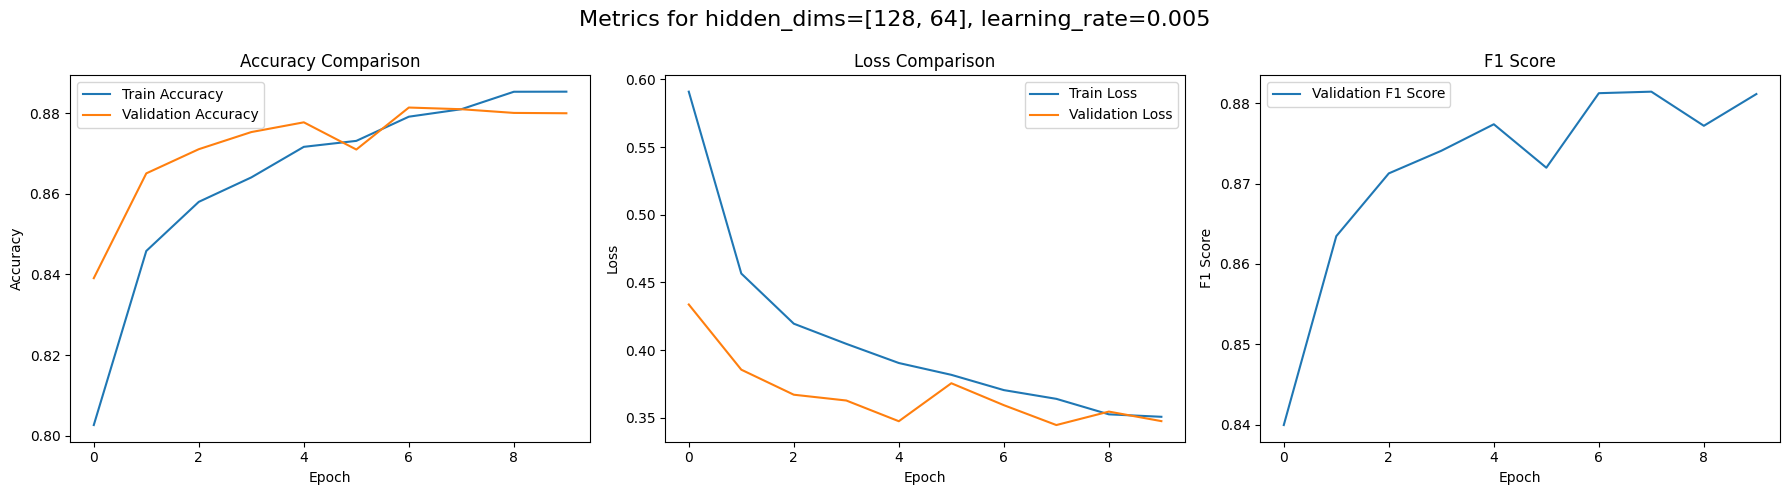

In [39]:
print(histories)
import matplotlib.pyplot as plt
# Function to plot training history
import matplotlib.pyplot as plt

# Function to plot training history
def plot_metrics(history, title="Training and Validation Metrics"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create a 1x3 grid of subplots

    # Plot for Accuracy
    axes[0].plot(history['train_acc'], label='Train Accuracy')
    axes[0].plot(history['val_acc'], label='Validation Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy Comparison')
    axes[0].legend()

    # Plot for Loss
    axes[1].plot(history['train_loss'], label='Train Loss')
    axes[1].plot(history['val_loss'], label='Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Loss Comparison')
    axes[1].legend()

    # Plot for F1 Score
    axes[2].plot(history['val_f1'], label='Validation F1 Score')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_title('F1 Score')
    axes[2].legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the title to fit
    plt.show()


for history in histories:
    plot_metrics(history, title=f"Metrics for hidden_dims={history['model_info'][0]}, learning_rate={history['model_info'][1]}")

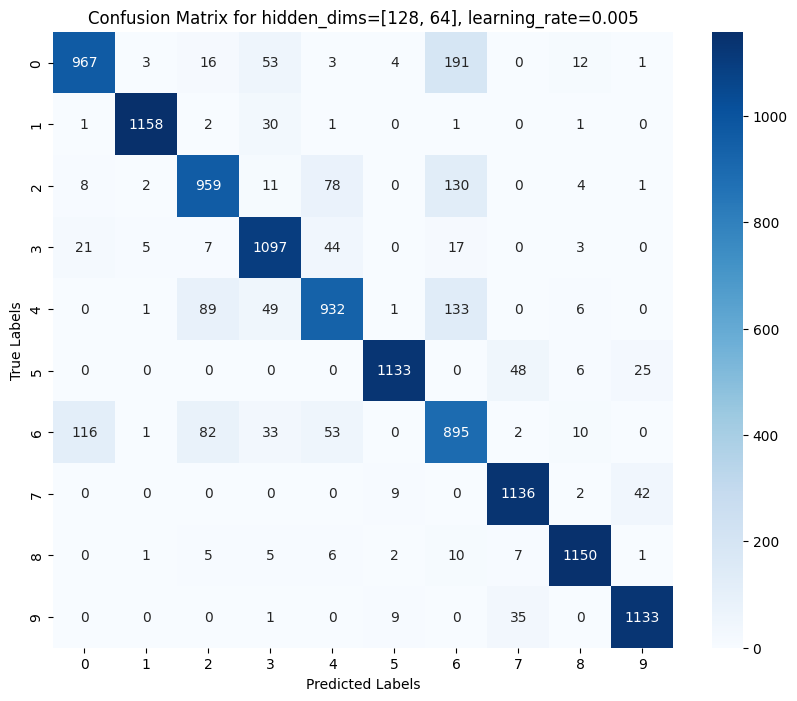

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

for history in histories:
    # Plotting the confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(history['confusion_mat'][0], annot=True, fmt="d", cmap="Blues", xticklabels=range(output_dim), yticklabels=range(output_dim))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for hidden_dims={history['model_info'][0]}, learning_rate={history['model_info'][1]}')
    plt.show()

In [41]:
max_f1_score = 0
best_history = None

for history in histories:
    print(f'for hidden_dims={history['model_info'][0]}, learning_rate={history['model_info'][1]} f1 score: {history['val_f1'][num_epochs-1]}')
    if history['val_f1'][num_epochs-1] > max_f1_score:
        max_f1_score = history['val_f1'][num_epochs-1]
        best_history = history

for hidden_dims=[128, 64], learning_rate=0.005 f1 score: 0.8811308008659535


In [42]:
history_final = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': [], 'model_info':[],'confusion_mat':[]}
history_final['model_info'].append(best_history['model_info'][0])
history_final['model_info'].append(best_history['model_info'][1])

train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model_current = Model(input_dim,best_history['model_info'][0],output_dim,dropout_rate,best_history['model_info'][1],batch_size,num_epochs)
model = model_current.fit(train_loader_full,history_final,train=False)

10


100%|██████████| 938/938 [00:12<00:00, 75.05it/s]


total:  60000 correct:  48541
Epoch [1/10], Loss: 0.5693, Accuracy: 0.8090


100%|██████████| 938/938 [00:11<00:00, 83.75it/s]


total:  60000 correct:  51046
Epoch [2/10], Loss: 0.4451, Accuracy: 0.8508


100%|██████████| 938/938 [00:11<00:00, 85.15it/s]


total:  60000 correct:  51613
Epoch [3/10], Loss: 0.4168, Accuracy: 0.8602


100%|██████████| 938/938 [00:11<00:00, 85.01it/s]


total:  60000 correct:  52140
Epoch [4/10], Loss: 0.3934, Accuracy: 0.8690


100%|██████████| 938/938 [00:11<00:00, 83.51it/s]


total:  60000 correct:  52471
Epoch [5/10], Loss: 0.3800, Accuracy: 0.8745


100%|██████████| 938/938 [00:11<00:00, 82.52it/s]


total:  60000 correct:  52699
Epoch [6/10], Loss: 0.3690, Accuracy: 0.8783


100%|██████████| 938/938 [00:11<00:00, 81.71it/s]


total:  60000 correct:  52899
Epoch [7/10], Loss: 0.3627, Accuracy: 0.8817


100%|██████████| 938/938 [00:12<00:00, 74.79it/s]


total:  60000 correct:  53097
Epoch [8/10], Loss: 0.3573, Accuracy: 0.8850


100%|██████████| 938/938 [00:11<00:00, 78.53it/s]


total:  60000 correct:  53260
Epoch [9/10], Loss: 0.3465, Accuracy: 0.8877


100%|██████████| 938/938 [00:11<00:00, 78.94it/s]

total:  60000 correct:  53341
Epoch [10/10], Loss: 0.3424, Accuracy: 0.8890


In [47]:
# DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
Test(model,test_loader)

Test Accuracy: 86.38%


In [44]:
import pickle

# Save the trained model to a file
with open('fashion_mnist_model.pkl', 'wb') as file:
    pickle.dump(model, file)
print("Model saved successfully!")


Model saved successfully!


In [45]:
# Load the model from the file
with open('fashion_mnist_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully!")


Model loaded successfully!


In [46]:
Test(loaded_model,test_loader)

Test Accuracy: 86.47%
